<a href="https://colab.research.google.com/github/hooda3789/Diabetic-Retinopathy-Prediction/blob/main/mp_diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import tensorflow_datasets as tfds
from keras.models import Sequential,Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation,BatchNormalization,concatenate,Input
from keras import losses
from keras.optimizers import Adam, Adagrad,SGD
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import model_from_json
from sklearn.model_selection import GridSearchCV
import keras
from keras.layers import LeakyReLU
import os


In [ ]:
# import shutil
# shutil.rmtree("/content/data")

In [ ]:
import zipfile      #this block loads the data and extracts it in colab's storage
local_zip = '/content/drive/My Drive/Data/ret_data.zip'    # enter the dataset's zip folder location
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')    #enter destination location

zip_ref.close()

In [ ]:
import os
train_horse_dir = os.path.join('/content/data/train/Tlevel0')
print('total t1 images:', len(os.listdir(train_horse_dir)))


total t1 images: 18840


In [ ]:
import numpy as np
import cv2

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def GaussianBlur_PreProcess(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
# res=circle_crop(image,33)

In [ ]:
train_path='/content/data/train'
test_path='/content/data/test/'

In [ ]:

for level in os.listdir(test_path):
  for my_image in os.listdir(test_path + "/" + level):
    im = cv2.imread(test_path + "/" + level + '/' + my_image)
    res = GaussianBlur_PreProcess(im, 33)
    path = '/content/prepros_data/TRAIN_Resizedvgg net/' + level + '/'
    os.makedirs(path,exist_ok =True)
    # cv2.imwrite('/content/prepros_data/TRAIN_Resizedvgg net/' + level + '/' + my_image, res)
    cv2.imwrite(os.path.join(path , my_image), res)

In [ ]:
from zipfile import ZipFile
import os
from os.path import basename
# create a ZipFile object
for level in os.listdir('/content/prepros_data/TRAIN_Resizedvgg net'):
  with ZipFile(level+'.zip', 'w') as zipObj:
    # Iterate over all the files in directory
    for folderName, subfolders, filenames in os.walk('/content/prepros_data/TRAIN_Resizedvgg net/'+level):
        for filename in filenames:
            #create complete filepath of file in directory
            filePath = os.path.join(folderName, filename)
            # Add file to zip
            zipObj.write(filePath, basename(filePath))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.regularizers import l1_l2,l1,l2

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x= Dense(128,kernel_regularizer=l2(0.05), bias_regularizer=l2(0.02))(x)


x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.06), bias_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
final_output = Dense(5, activation='softmax', name='final_output')(x)
model = Model(inputs=input_tensor, outputs=final_output)


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,epsilon=1e-08,learning_rate=0.0001), metrics=["accuracy"])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 111, 111, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 111, 111, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory( train_path,
   # '../input/train_resizedvgg net/',
    target_size=(224,224),
    batch_size=32
    ,shuffle=True
)
validation_generator = validation_datagen.flow_from_directory( test_path,
     #   '../input/test_resizedvgg net/',
        target_size=(224,224),
        batch_size=32,
        shuffle=True)

Found 25451 images belonging to 5 classes.
Found 9675 images belonging to 5 classes.


In [ ]:
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=["accuracy"])
from collections import Counter
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs['accuracy']>0.8 and logs['val_accuracy']>0.7):
                print("\n 99% acc reached")
                model.stop_training = True

modelhist = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=[CustomCallback()]
        )

Epoch 1/30
796/796 [==============================] - 475s 596ms/step - loss: 22.4676 - accuracy: 0.2949 - val_loss: 15.6051 - val_accuracy: 0.1710
Epoch 2/30
796/796 [==============================] - 472s 592ms/step - loss: 15.7586 - accuracy: 0.3504 - val_loss: 9.6154 - val_accuracy: 0.2834
Epoch 3/30
796/796 [==============================] - 473s 594ms/step - loss: 10.7346 - accuracy: 0.3738 - val_loss: 6.0442 - val_accuracy: 0.2112
Epoch 4/30
796/796 [==============================] - 471s 592ms/step - loss: 7.6128 - accuracy: 0.3598 - val_loss: 4.2008 - val_accuracy: 0.3193
Epoch 5/30
796/796 [==============================] - 473s 594ms/step - loss: 5.7040 - accuracy: 0.3704 - val_loss: 3.1327 - val_accuracy: 0.1579
Epoch 6/30
796/796 [==============================] - 472s 594ms/step - loss: 4.7283 - accuracy: 0.3718 - val_loss: 2.7212 - val_accuracy: 0.2165
Epoch 7/30
796/796 [==============================] - 473s 594ms/step - loss: 3.8220 - accuracy: 0.3896 - val_loss: 2.29

In [ ]:
[loss, acc] = model.evaluate_generator(train_generator)
print("Train accuracy is : " + str(acc))
print("Train loss is : " + str(loss))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Train accuracy is : 0.9811402559280396
Train loss is : 0.20706066489219666


In [ ]:
[loss, acc] = model.evaluate_generator(validation_generator)
print("Validation accuracy is : " + str(acc))
print("Validation loss is : " + str(loss))

Validation accuracy is : 0.6907493472099304
Validation loss is : 1.5674618482589722


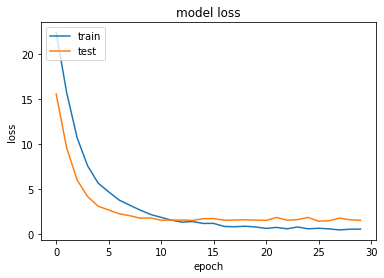

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelhist.history['loss'])
plt.plot(modelhist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("km_loss.png")
plt.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
